In [2]:
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [3]:
df = pd.read_csv("./DataNewFeaturesNoNormalization.csv")

In [4]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["MM"] = df["datetime"].dt.month

In [5]:
df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
df = df.set_index('datetime')
df.head()

,HOUR,SEASON,origin,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,AIR_WATER_TMP_DIFF,MM
datetime,,,,,,,,,,,,,,,
2018-09-19 04:40:00,4,1,0,81.0,6.3,8.1,1.68,8.33,6.00,114.0,1013.8,25.9,26.5,0.6,9
2018-09-19 05:40:00,5,1,0,78.0,9.6,12.9,1.70,8.33,5.97,108.0,1014.4,25.0,26.4,1.4,9
2018-09-19 06:40:00,6,1,0,109.0,6.5,9.6,1.80,7.14,6.21,101.0,1015.2,23.3,26.4,3.1,9
2018-09-19 07:40:00,7,1,0,83.0,4.5,9.7,1.74,8.33,6.23,91.0,1015.5,25.1,26.4,1.3,9
2018-09-19 08:40:00,8,1,0,83.0,4.7,6.0,1.84,7.14,6.06,89.0,1015.9,25.2,26.4,1.2,9


## origin: 0 -> station 1, origin: 1 -> station 2, origin: 2 -> filled with median

In [6]:
df = df[df["origin"] == 0]
df.drop(columns = ["origin"], axis = 1, inplace=True)

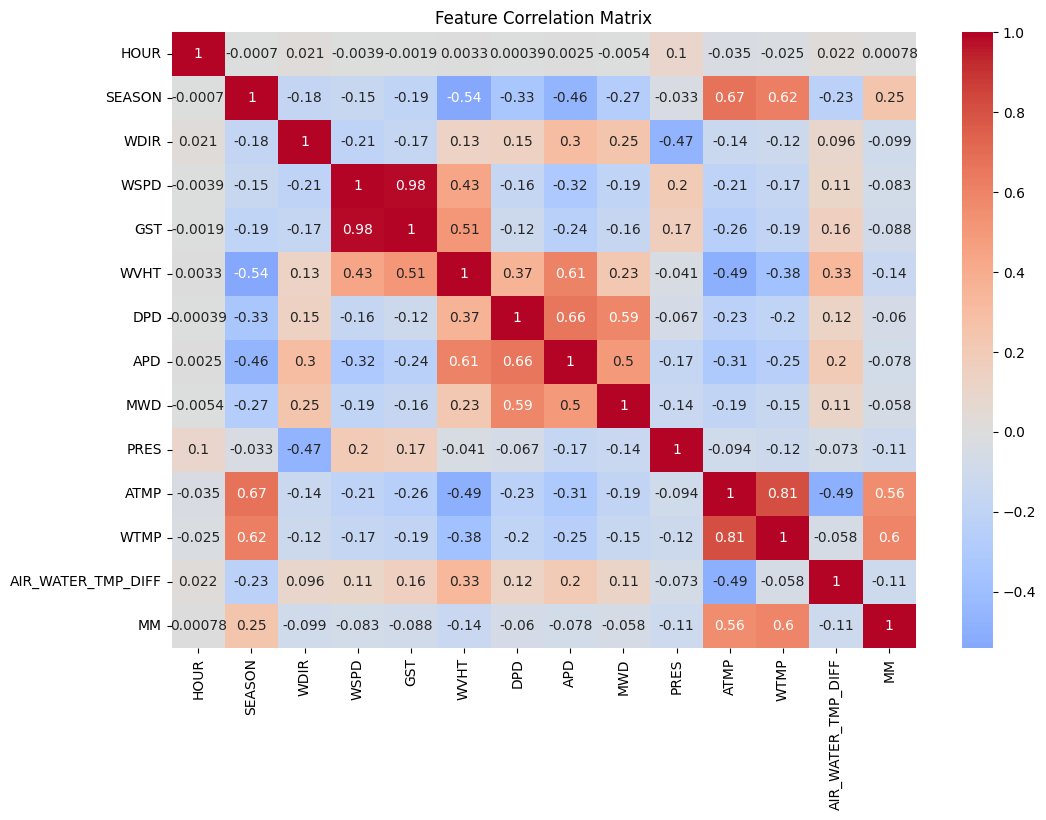

WVHT                  1.000000
APD                   0.605558
GST                   0.506569
WSPD                  0.434019
DPD                   0.365960
AIR_WATER_TMP_DIFF    0.329448
MWD                   0.229204
WDIR                  0.131885
HOUR                  0.003261
PRES                 -0.040876
MM                   -0.140345
WTMP                 -0.375215
ATMP                 -0.493947
SEASON               -0.541402
Name: WVHT, dtype: float64


In [7]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.show()

print(corr['WVHT'].sort_values(ascending=False))

In [8]:
# from sklearn.feature_selection import mutual_info_regression

# X = df.drop(columns=['WVHT'], axis = 1)
# y = df['WVHT']

# X = X.fillna(0)

# mi = mutual_info_regression(X, y)
# mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
# print(mi_series)

In [9]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# rf.fit(X, y)
# importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
# print(importances)

In [10]:
# plt.plot(range(len(df["WVHT"])), df["WVHT"])
# plt.show()

In [11]:
features = ['SEASON', 'WDIR', 'WSPD','GST','DPD','APD','MWD','PRES','ATMP','WTMP','AIR_WATER_TMP_DIFF', 'MM']
target = 'WVHT'

In [12]:
# plt.figure(figsize=(12,6))
# plt.scatter(df["SEASON"], df["WVHT"], alpha=0.5)
# plt.xlabel("Season")
# plt.ylabel("WVHT")
# plt.title("WVHT over Seasons")
# plt.show()

In [13]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [14]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

In [15]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, shuffle=False)

In [16]:
sequence_length = 24
batch_size = 32

train_dataset = timeseries_dataset_from_array(
    data=X_train_final,
    targets=y_train_final,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

val_dataset = timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

test_dataset = timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_scaled,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=False
)

In [17]:
num_train_sequences = sum(1 for _ in train_dataset)
num_val_sequences = sum(1 for _ in val_dataset)
print(num_train_sequences, num_val_sequences)

1088 272


2025-10-18 22:37:21.760137: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-18 22:37:21.882020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
model = Sequential([
    Input(shape=(sequence_length, len(features))),
    LSTM(50, activation='tanh', input_shape=(sequence_length, len(features))),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/Users/divyanshpurohit/Desktop/Projects/Jupyter NB/venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        12,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,651 (49.42 KB)

 Trainable params: 12,651 (49.42 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0066 - mae: 0.0597 - val_loss: 0.0097 - val_mae: 0.0670
Epoch 2/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0043 - mae: 0.0479 - val_loss: 0.0083 - val_mae: 0.0647
Epoch 3/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0036 - mae: 0.0433 - val_loss: 0.0066 - val_mae: 0.0591
Epoch 4/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0030 - mae: 0.0388 - val_loss: 0.0051 - val_mae: 0.0526
Epoch 5/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0026 - mae: 0.0367 - val_loss: 0.0048 - val_mae: 0.0518
Epoch 6/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0024 - mae: 0.0353 - val_loss: 0.0047 - val_mae: 0.0516
Epoch 7/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0023 - mae: 0.0343 - val_loss: 0.0048 - val_mae: 0.0524
Epoch 8/50
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0021 - mae: 0.0335 - val_loss: 0.0045 - val_mae: 0.0504
Epoch 9/50
1088/1088 ━━━━━━━━━━━━━━━━━━━

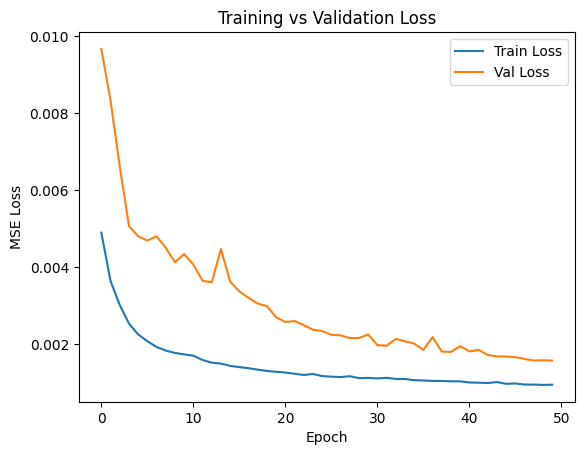

In [20]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [21]:
y_pred_scaled = model.predict(test_dataset)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled[sequence_length-1:])  # first few can't be predicted

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 0.651, MAE: 0.424, R2: 0.466


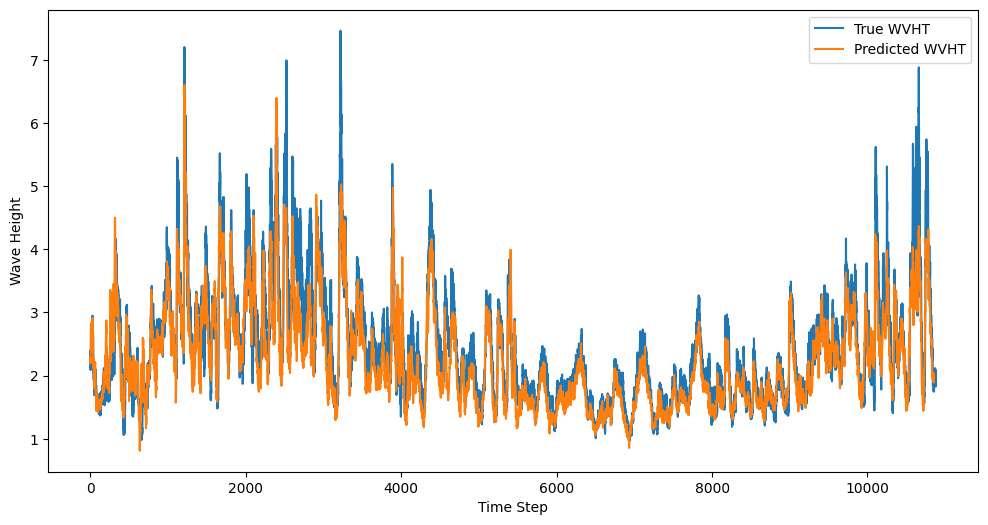

In [22]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='True WVHT')
plt.plot(y_pred, label='Predicted WVHT')
plt.xlabel('Time Step')
plt.ylabel('Wave Height')
plt.legend()
plt.show()

In [25]:
min_len = min(len(y_pred.flatten()), len(y_test.flatten()))
y_pred_aligned = y_pred.flatten()[:min_len]
y_true_aligned = y_test.flatten()[:min_len]


timestamps = df.index[-min_len:]


df_eval = df.loc[timestamps].copy()
df_eval = df_eval.assign(
    y_true=y_true_aligned,
    y_pred=y_pred_aligned
)
df_eval["residual"] = df_eval["y_true"] - df_eval["y_pred"]
df_eval["squared_error"] = df_eval["residual"] ** 2
df_eval["month"] = df_eval.index.month
df_eval["week"] = df_eval.index.isocalendar().week.astype(int)
df_eval.head()

,HOUR,SEASON,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,AIR_WATER_TMP_DIFF,MM,y_true,y_pred,residual,squared_error,month,week
datetime,,,,,,,,,,,,,,,,,,,,
2023-10-05 11:40:00,11,1,50.0,7.5,8.9,2.22,13.79,6.90,2.0,1014.3,25.9,26.9,1.0,10,2.39,2.273665,0.116335,0.013534,10,40
2023-10-05 12:40:00,12,1,48.0,7.1,9.0,2.54,13.79,7.70,5.0,1014.2,26.0,26.9,0.9,10,2.25,2.194506,0.055494,0.003080,10,40
2023-10-05 13:40:00,13,1,50.0,7.3,9.1,2.37,12.90,7.56,0.0,1014.0,25.8,26.9,1.1,10,2.09,2.219461,-0.129461,0.016760,10,40
2023-10-05 14:40:00,14,1,37.0,7.9,10.0,2.58,12.90,7.56,2.0,1014.1,25.8,26.9,1.1,10,2.40,2.339511,0.060489,0.003659,10,40
2023-10-05 15:40:00,15,1,46.0,7.2,8.7,2.95,12.90,8.21,6.0,1014.3,25.8,26.9,1.1,10,2.36,2.383430,-0.023430,0.000549,10,40


In [26]:
def discretize(df, cols, q=4):
    for c in cols:
        df[f"{c}_bin"] = pd.qcut(df[c].rank(method='first'), q=q, duplicates='drop')
    return df

cont_features = ["WSPD", "WVHT", "DPD", "ATMP", "WTMP", "AIR_WATER_TMP_DIFF", "SEASON"]
df_eval = discretize(df_eval, cont_features, q=4)
df_eval.head()

,HOUR,SEASON,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,...,squared_error,month,week,WSPD_bin,WVHT_bin,DPD_bin,ATMP_bin,WTMP_bin,AIR_WATER_TMP_DIFF_bin,SEASON_bin
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-05 11:40:00,11,1,50.0,7.5,8.9,2.22,13.79,6.90,2.0,1014.3,...,0.013534,10,40,"(5429.5, 8143.75]","(2715.25, 5429.5]","(8143.75, 10858.0]","(5429.5, 8143.75]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]"
2023-10-05 12:40:00,12,1,48.0,7.1,9.0,2.54,13.79,7.70,5.0,1014.2,...,0.003080,10,40,"(5429.5, 8143.75]","(5429.5, 8143.75]","(8143.75, 10858.0]","(8143.75, 10858.0]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]"
2023-10-05 13:40:00,13,1,50.0,7.3,9.1,2.37,12.90,7.56,0.0,1014.0,...,0.016760,10,40,"(5429.5, 8143.75]","(5429.5, 8143.75]","(5429.5, 8143.75]","(5429.5, 8143.75]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]"
2023-10-05 14:40:00,14,1,37.0,7.9,10.0,2.58,12.90,7.56,2.0,1014.1,...,0.003659,10,40,"(5429.5, 8143.75]","(5429.5, 8143.75]","(5429.5, 8143.75]","(5429.5, 8143.75]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]"
2023-10-05 15:40:00,15,1,46.0,7.2,8.7,2.95,12.90,8.21,6.0,1014.3,...,0.000549,10,40,"(5429.5, 8143.75]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]","(8143.75, 10858.0]","(5429.5, 8143.75]","(5429.5, 8143.75]"


In [27]:
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def time_aware_Q(subset, global_rmse, lambda_t=0.25):
    rmse_t = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
    if len(rmse_t) < 3:
        return None
    mean_rmse = rmse_t.mean()
    var_rmse = rmse_t.var()
    Q = (mean_rmse - global_rmse) - lambda_t * var_rmse
    return Q, mean_rmse, var_rmse

In [28]:
def scape_temporal(df, feature_cols, min_support=100, lambda_t=0.25, top_k=10):
    global_rmse = compute_rmse(df["y_true"], df["y_pred"])
    results = []
    for col in tqdm(feature_cols):
        for val in df[col].unique():
            subset = df[df[col] == val]
            if len(subset) < min_support:
                continue
            out = time_aware_Q(subset, global_rmse, lambda_t)
            if out is None:
                continue
            Q, mean_rmse, var_rmse = out
            results.append({
                "rule": [(col, val)],
                "Q": Q,
                "mean_rmse": mean_rmse,
                "var_rmse": var_rmse,
                "support": len(subset)
            })

    results = sorted(results, key=lambda x: x["Q"], reverse=True)[:top_k]
    return results, global_rmse

binned_features = [f"{c}_bin" for c in cont_features]
results, global_rmse = scape_temporal(df_eval, binned_features, min_support=100, lambda_t=0.25, top_k=10)

print(f"Global RMSE = {global_rmse:.4f}\nTop exceptional subgroups:")
for r in results:
    print(f"{r['rule']} | Q={r['Q']:.3f}, n={r['support']}, mean_RMSE={r['mean_rmse']:.3f}")

  0%|                                                     | 0/7 [00:00<?, ?it/s]/var/folders/_g/k9x9_gwd40gbw9_v7c_0b8n00000gn/T/ipykernel_9080/824560013.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_t = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
/var/folders/_g/k9x9_gwd40gbw9_v7c_0b8n00000gn/T/ipykernel_9080/824560013.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
 

Global RMSE = 0.4237
Top exceptional subgroups:
[('SEASON_bin', Interval(0.999, 2715.25, closed='right'))] | Q=0.124, n=2715, mean_RMSE=0.558
[('WTMP_bin', Interval(0.999, 2715.25, closed='right'))] | Q=0.062, n=2715, mean_RMSE=0.503
[('WVHT_bin', Interval(8143.75, 10858.0, closed='right'))] | Q=0.036, n=2715, mean_RMSE=0.469
[('WSPD_bin', Interval(0.999, 2715.25, closed='right'))] | Q=-0.006, n=2715, mean_RMSE=0.430
[('ATMP_bin', Interval(0.999, 2715.25, closed='right'))] | Q=-0.019, n=2715, mean_RMSE=0.416
[('SEASON_bin', Interval(2715.25, 5429.5, closed='right'))] | Q=-0.019, n=2714, mean_RMSE=0.405
[('DPD_bin', Interval(8143.75, 10858.0, closed='right'))] | Q=-0.032, n=2715, mean_RMSE=0.402
[('DPD_bin', Interval(5429.5, 8143.75, closed='right'))] | Q=-0.040, n=2714, mean_RMSE=0.396
[('AIR_WATER_TMP_DIFF_bin', Interval(8143.75, 10858.0, closed='right'))] | Q=-0.041, n=2715, mean_RMSE=0.392
[('WSPD_bin', Interval(2715.25, 5429.5, closed='right'))] | Q=-0.047, n=2714, mean_RMSE=0.386


/var/folders/_g/k9x9_gwd40gbw9_v7c_0b8n00000gn/T/ipykernel_9080/2141823288.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_month = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))


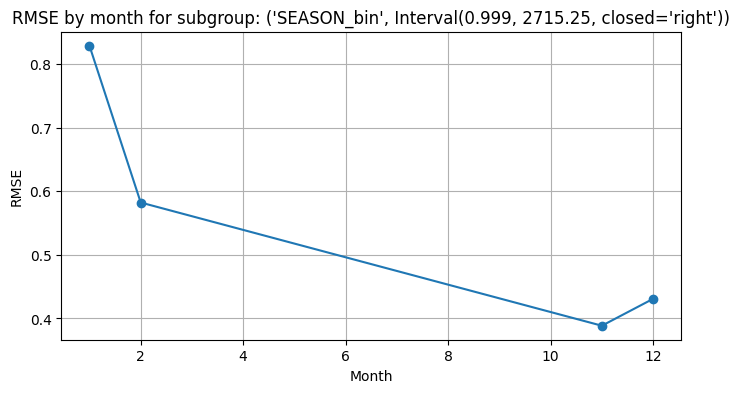

In [30]:
def plot_rmse_trend(df, rule):
    subset = df[df[rule[0][0]] == rule[0][1]]
    rmse_month = subset.groupby("month").apply(lambda x: compute_rmse(x["y_true"], x["y_pred"]))
    plt.figure(figsize=(8,4))
    plt.plot(rmse_month.index, rmse_month.values, marker='o')
    plt.title(f"RMSE by month for subgroup: {rule[0]}")
    plt.xlabel("Month")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

plot_rmse_trend(df_eval, results[0]["rule"])